In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [383]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])


#we can only keep clusters whose first article occured after the 
#first day of local coverage in our data, 4/1
firstLocDate = min(df.loc[df["national"] == False, "date"])
clusteredDates = df[["clustNum", "date"]].groupby(by="clustNum").agg(list).reset_index()
clusteredDates["minDate"] = clusteredDates["date"].apply(lambda x: min(x))
keepClusts = clusteredDates.loc[clusteredDates["minDate"] >= firstLocDate, "clustNum"]

df = df[df["clustNum"].isin(keepClusts)]
len(df)


<ipython-input-383-f9b757047d9d>:2: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


690039

In [386]:
#get each date as a date since the first story in our data 
#get the first date in our dataset 
minDate = min(df["date"])

df["dateInt"] = df["date"].apply(lambda x: (x - minDate) / np.timedelta64(1, "D"))

In [387]:
minDate

Timestamp('2020-04-01 00:00:00')

In [388]:
#get largest stories 
clustDf = df[["source", "clustNum", "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby("clustNum").agg(list).reset_index()
clustDf["clustSize"] = clustDf["key"].apply(len)
clustDf["nationalPercent"] = clustDf["national"].apply(np.mean)
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
clustDf["numStates"] = clustDf["state"].apply(getUnique)

In [390]:
#get variance of our date integer 
clustDf["dateStd"] = clustDf["dateInt"].apply(np.std) 

<Axes: xlabel='dateStd', ylabel='Density'>

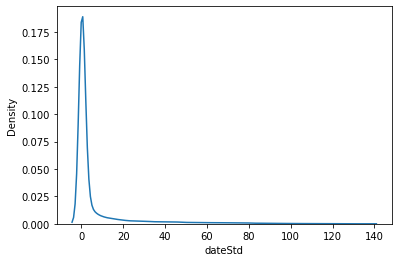

In [75]:
sns.kdeplot(x="dateStd", data=clustDf)

In [108]:
#consideration: maybe make a cutoff using the variance of news story duration? 

In [102]:
clustDf.loc[clustDf["clustNum"] == 12298.0, ["source", "title", "dateInt"]].explode(["source", "title", "dateInt"]).head(4)

,source,title,dateInt
9545,therepublic,Couple draw guns at crowd heading to St. Louis...,89.0
9545,startribune,Couple draw guns at crowd heading to St. Louis...,89.0
9545,murrysvillestar,Couple draw guns at crowd heading to St. Louis...,89.0
9545,pittsburghtribunereview,Couple draw guns at crowd heading to St. Louis...,89.0


Text(0.5, 1.0, 'Timeline of White Couple Pointing Guns at Protestors')

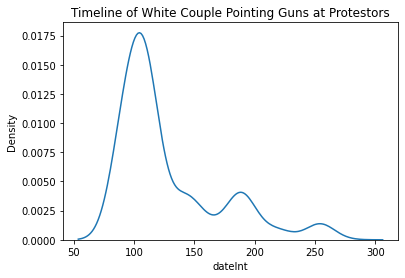

In [91]:
whiteCoupleDf = clustDf.loc[clustDf["clustNum"] == 12298.0, ["source", "title", "dateInt"]].explode(["source", "title", "dateInt"])
sns.kdeplot(x="dateInt", data=whiteCoupleDf,)
plt.title("Timeline of White Couple Pointing Guns at Protestors")

In [ ]:
clustDf.loc[clustDf["clustNum"] == 12298.0, ["source", "title", "dateInt"]].explode(["source", "title", "dateInt"])

In [49]:
clustDf.loc[clustDf["clustNum"] == 899.0].explode(["source", "national", "key", "content", "title"]).sample(10)

,clustNum,source,national,key,content,title,clustSize,nationalPercent
698,899.0,waterburyrepublicanamerican,False,560774,"Today is Saturday, Nov. 14, the 319th day of 2...","Today in History, Nov. 14",696,0.261494
698,899.0,abcnews,True,1822163,"Today is Sunday , Nov. 15 , the 320th day of 2...",Today in History,696,0.261494
698,899.0,thesidneydailynews,False,99193,"Today is Monday, May 11, the 132nd day of 2020...",Today in history,696,0.261494
698,899.0,wilmingtonnewsjournal,False,127611,"Today is Friday, May 22, the 143rd day of 2020...",TODAY IN HISTORY,696,0.261494
698,899.0,austindailyherald,False,147314,"Today is Saturday, May 30, the 151st day of 20...","Today in History: May 30, 2020",696,0.261494
698,899.0,abcnews,True,1822391,"Today is Saturday , Nov. 28 , the 333rd day of...",Today in History,696,0.261494
698,899.0,wilmingtonnewsjournal,False,573758,"Today is Friday, Nov. 20, the 325th day of 202...",TODAY IN HISTORY,696,0.261494
698,899.0,wilmingtonnewsjournal,False,558685,"Today is Friday, Nov. 13, the 318th day of 202...",TODAY IN HISTORY,696,0.261494
698,899.0,waterburyrepublicanamerican,False,608443,"Today is Monday, Dec. 7, the 342nd day of 2020...","Today in History, Dec. 7",696,0.261494
698,899.0,waterburyrepublicanamerican,False,112924,"Today is Saturday, May 16, the 137th day of 20...","Today in History, May 16",696,0.261494


In [44]:
list(df.loc[df["key"] == 3215647, "title"])

['Possible human remains found at site of ‘deliberate’ motorhome explosion']

In [ ]:
#political unrest in Belarus 
#nashville bombing 
#couple pointing guns at protestors 

In [513]:
#get the top stories in long format so we can plot their times series 
def generateTopStories(clustDf, topStoryNum, sortCol): 
    
    #typically sortCol will be "clustSize", but can also be spike size or something else 
    #get top number of stories for this column 
    topStories = clustDf.sort_values(sortCol, ascending=False).head(topStoryNum)

    #return the date ints that has the highest frequency in the inList of date ints 
    def maxDateInt(inList): 
        return Counter(inList).most_common()[0][0]

    #this will be used to sort stories by their peaks 
    topStories["topDay"] = topStories["dateInt"].apply(maxDateInt)

    def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
    #explode stories out from the story level, then group back again at the story,day level 
    topStories = topStories.explode(["source", "national", "key", "content", "title", "date", "dateInt", "lat", "lon", "state"])
    topStoriesDaily = topStories[["clustNum", "dateInt", "key", "topDay", "lat", "lon", "state"]].groupby(["clustNum", "dateInt"])\
    .agg({"key":len, "topDay":list, "state":getUnique, "lat":list, "lon":list}).reset_index()

    topStoriesDaily["topDay"] = topStoriesDaily["topDay"].apply(lambda x: x[0])
    
    return topStoriesDaily 


In [315]:
def plotTopStories(topStoriesDaily, storyType): 
    outTups = []
    fig, axs = plt.subplots(figsize=(7, 3))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)["clustNum"].unique()): 
        currColor = palette[i % len(palette)]
        currStories = topStoriesDaily[topStoriesDaily["clustNum"] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(df["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({"clustNum":clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")

        plt.plot(currStories["dateInt"], currStories["key"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        plt.fill_between(currStories.dateInt.values, currStories.key.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
    plt.title(f"Top {TOP_STORY_NUM} {storyType} Stories in Online English Publications: April 1 - December 31, 2020")
    plt.xlabel("day")
    plt.ylabel("number of articles")
    return outTups 

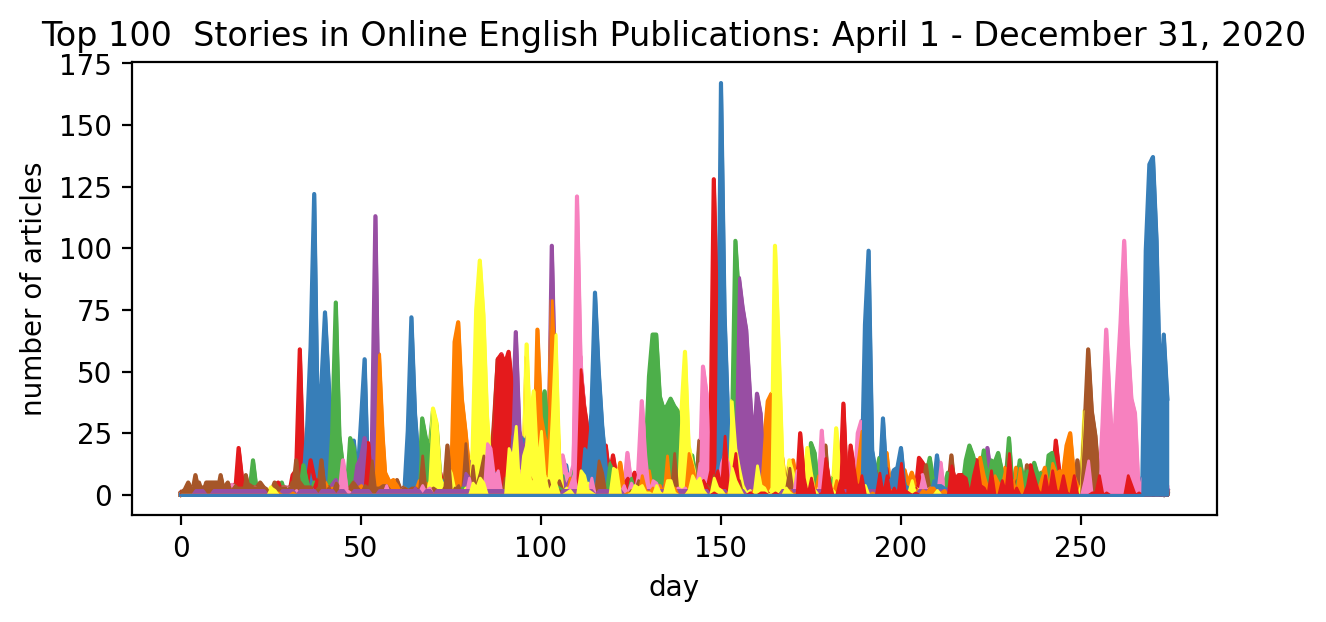

In [514]:
#first, look at the top 50 stories in general 
topStoriesDaily = generateTopStories(clustDf, 50, "clustSize")
allStories = plotTopStories(topStoriesDaily, "")

In [502]:
list(df[df["clustNum"] == 19927.0].sample(10)["title"])

['Ahmaud Arbery killing: Man who filmed shooting is arrested on suspicion of murder',
 'Arrests made in shooting death of black man after outcry',
 'Arrests Made in Shooting Death of Ahmaud Arbery',
 'Ahmaud Arbery shooting: Three men indicted on murder charges over death of jogger',
 '911 call, text hint at confrontation days before Arbery shot...',
 'Hundreds Demand Justice For Ahmaud Arbery At Georgia Rally',
 'Who was Ahmaud Arbery? The timeline of events in the tragic case',
 'Judge to weigh bond for father, son in Ahmaud Arbery slaying',
 'Judge rules there is enough evidence to try 3 men for murder of Ahmaud Arbery',
 'Arbery family lawyer: Feds looking into how case handled']

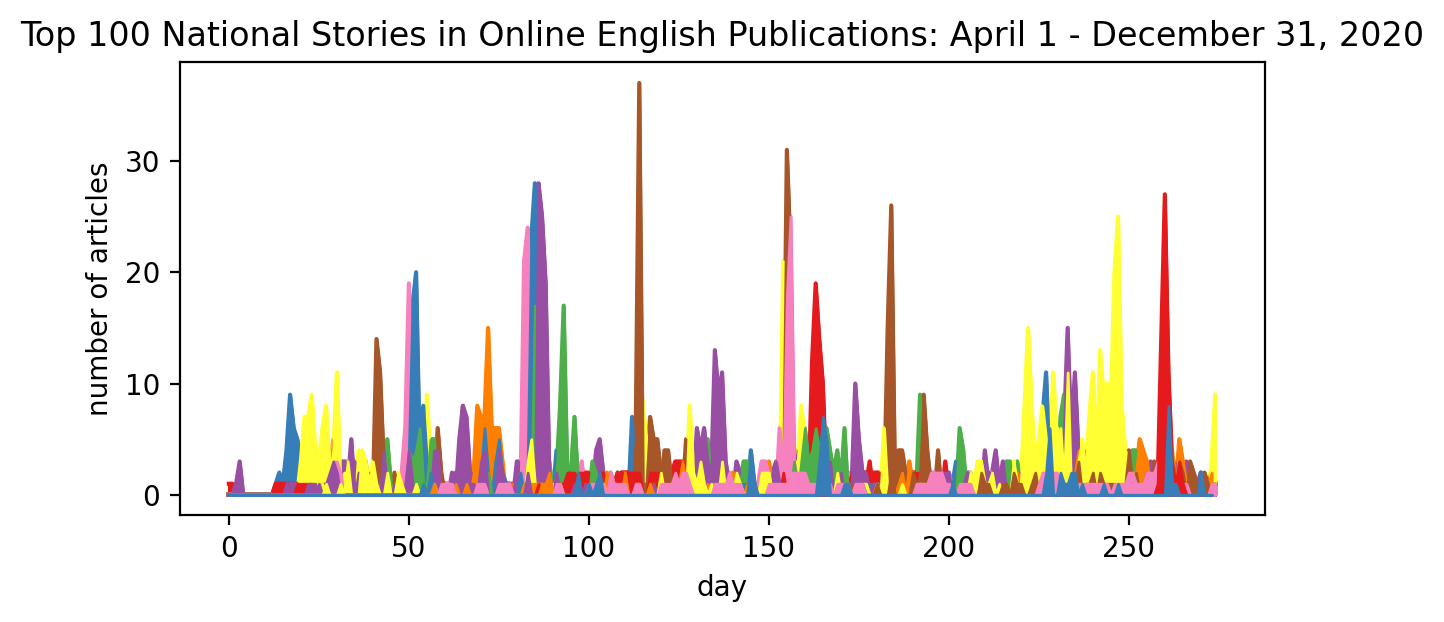

In [515]:
#look at only national stories 
nationalDf = clustDf[clustDf["nationalPercent"] == 1]
topNatStories = generateTopStories(nationalDf, 50, "clustSize")
natStories = plotTopStories(topNatStories, "National")

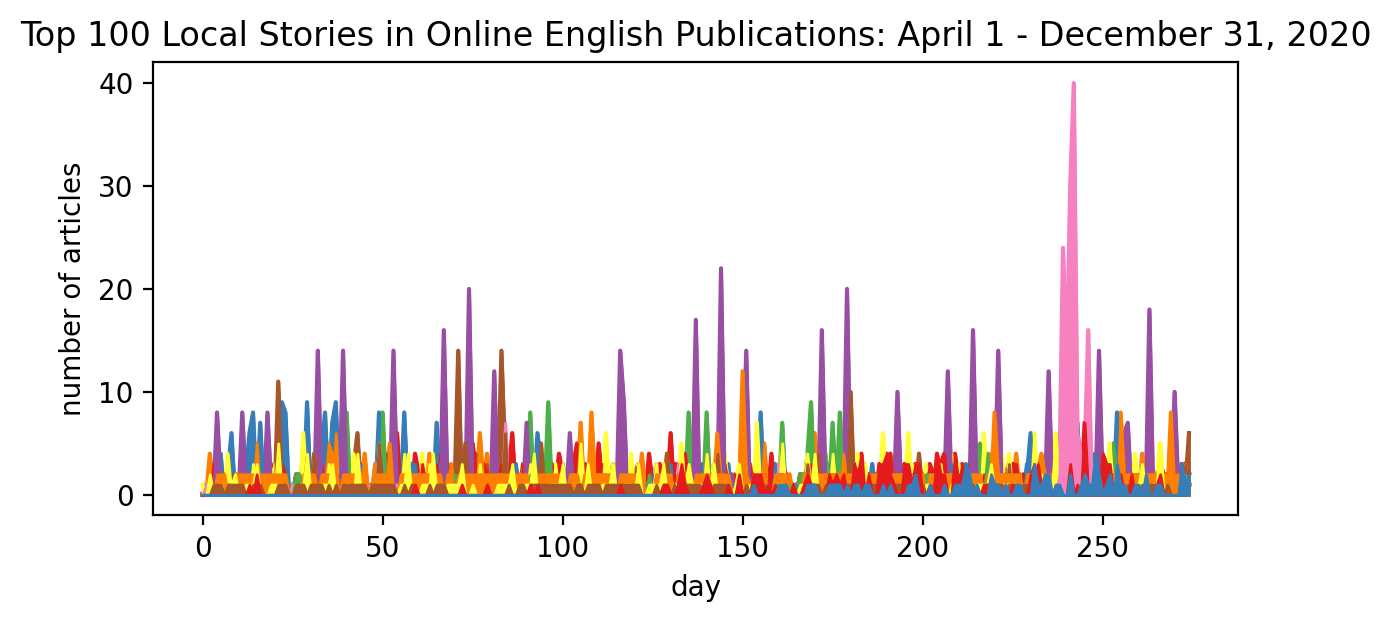

In [516]:
#look at only national stories 
plt.rcParams['figure.dpi'] = 200
localDf = clustDf[clustDf["nationalPercent"] == 0]
topLocalStories = generateTopStories(localDf, 50, "clustSize")
localStories = plotTopStories(topLocalStories, "Local")

In [342]:
#localStories

In [341]:
#list(df.loc[df["clustNum"] == 59231.0, "source"])

In [518]:
#now look at local stories in terms of tallest spikes 
clustDf["topDayInt"] = clustDf["dateInt"].apply(lambda x: Counter(x).most_common()[0][0])
clustDf["spikeSize"] = clustDf["dateInt"].apply(lambda x: Counter(x).most_common()[0][1])

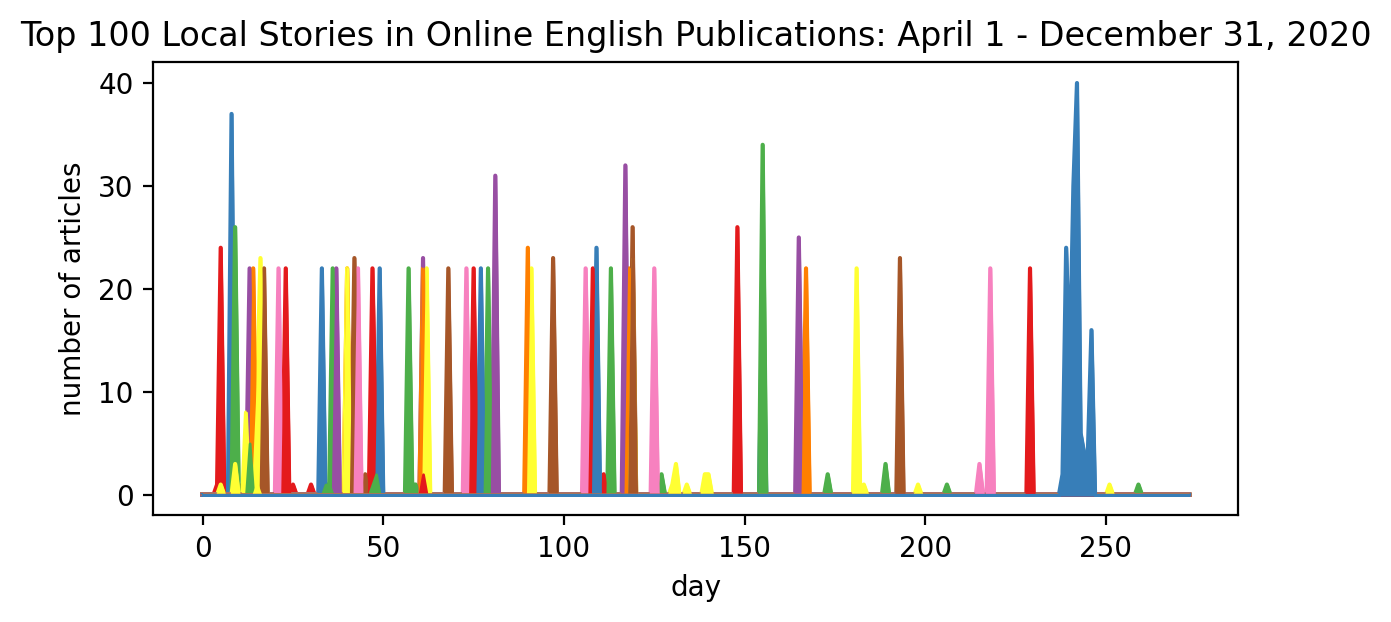

In [519]:
#look at only national stories 
plt.rcParams['figure.dpi'] = 200
localSpikesDf = clustDf[clustDf["nationalPercent"] == 0] #.sort_values("spikeSize", ascending=False)
topLocalSpikes = generateTopStories(localSpikesDf, 50, "spikeSize")
localSpikes = plotTopStories(topLocalSpikes, "Local")

In [534]:
def plotTopStoriesState(topStoriesDaily, storyType, storyNum, title=None): 
    outTups = []
    fig, axs = plt.subplots(figsize=(7, 3))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)["clustNum"].unique()): 
        currColor = palette[i % len(palette)]
        
        #get a particular set of stories (in df form)
        currStories = topStoriesDaily[topStoriesDaily["clustNum"] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(df["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({"clustNum":clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay, "state":0, "lat":0, "lon":0})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")
        
        
        plt.plot(currStories["dateInt"], currStories["state"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        plt.fill_between(currStories.dateInt.values, currStories.state.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
    if title == None: 
        plt.title(f"State-Level Spread of Top {storyNum} {storyType} Stories in Online English Publications: April 1 - December 31, 2020", fontsize=7)
    else: 
        plt.title(title, fontsize=7)
    plt.xlabel("day")
    plt.ylabel("number of states")
    plt.ylim(0, 30)
    return outTups 

In [452]:
stateClusts = generateStateClusts(clustDf, 50, "clustSize")

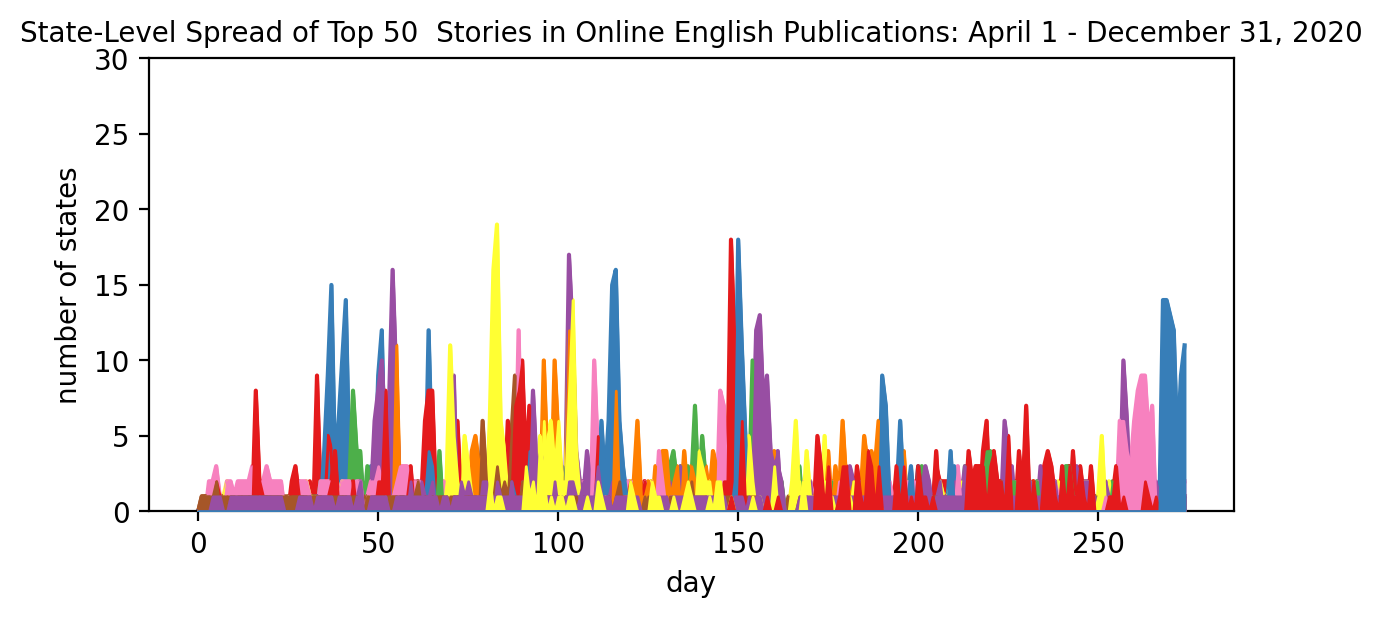

In [507]:
stateStories = plotTopStoriesState(stateClusts, "", 50)

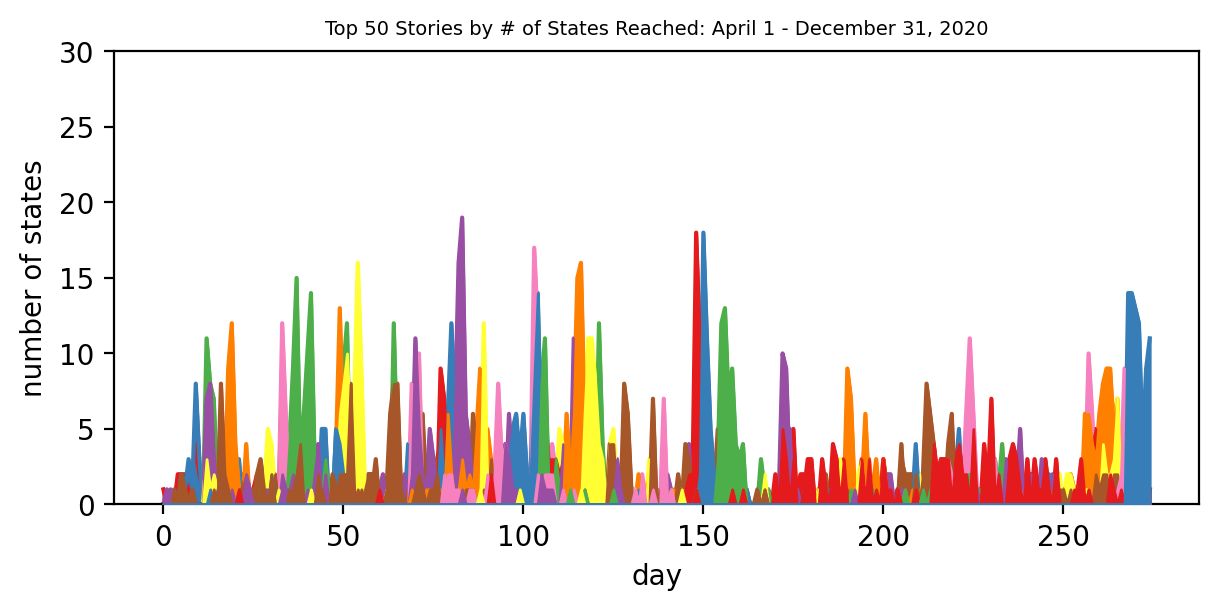

In [535]:
topStateStories = generateTopStories(clustDf, 50, "numStates").sort_values("state", ascending=False)
topStateClusts = plotTopStoriesState(topStateStories, "", 50, "Top 50 Stories by # of States Reached: April 1 - December 31, 2020")

In [529]:
topStateClusts

[(32360.0, '#e41a1c', 9.0),
 (32772.0, '#377eb8', 9.0),
 (16287.0, '#4daf4a', 12.0),
 (2804.0, '#984ea3', 12.0),
 (24182.0, '#ff7f00', 19.0),
 (3113.0, '#ffff33', 29.0),
 (6924.0, '#a65628', 33.0),
 (493.0, '#f781bf', 33.0),
 (20335.0, '#e41a1c', 35.0),
 (9078.0, '#377eb8', 36.0),
 (19927.0, '#4daf4a', 37.0),
 (8473.0, '#984ea3', 43.0),
 (5538.0, '#ff7f00', 49.0),
 (397.0, '#ffff33', 54.0),
 (4839.0, '#a65628', 64.0),
 (15207.0, '#f781bf', 70.0),
 (2378.0, '#e41a1c', 77.0),
 (1950.0, '#377eb8', 80.0),
 (15862.0, '#4daf4a', 83.0),
 (29.0, '#984ea3', 83.0),
 (1008.0, '#ff7f00', 88.0),
 (12298.0, '#ffff33', 89.0),
 (8491.0, '#a65628', 98.0),
 (688.0, '#f781bf', 103.0),
 (10803.0, '#e41a1c', 104.0),
 (2297.0, '#377eb8', 104.0),
 (22282.0, '#4daf4a', 106.0),
 (32819.0, '#984ea3', 114.0),
 (1337.0, '#ff7f00', 115.0),
 (21839.0, '#ffff33', 117.0),
 (6514.0, '#a65628', 128.0),
 (17442.0, '#f781bf', 139.0),
 (241.0, '#e41a1c', 148.0),
 (819.0, '#377eb8', 150.0),
 (1763.0, '#4daf4a', 155.0),
 (6

In [543]:
df[df["clustNum"] == 20782.0].sort_values("date")

,Unnamed: 0,key,local_id,sourcedomain_id,date,title,content,url,fips,source,...,predrt_3,national,id,author,published,published_utc,collection_utc,year,clustNum,dateInt
472314,472314,472314,thedailyrepublic--2020-10-08--Expert: Michigan...,thedailyrepublic-dailyrepublic.com,2020-10-08,Expert: Michigan ‘a hotbed for militia activit...,DETROIT — A foiled plot to kidnap Michigan Gov...,https://www.dailyrepublic.com/all-dr-news/wire...,6095.0,thedailyrepublic,...,25.13,False,NaN,NaN,NaN,NaN,NaN,2020,20782.0,190.0
1719506,1719506,2501862,NaN,NaN,2020-10-08,Narrative Fail: Turns Out the Folks Behind th...,"As we reported previously , the FBI busted up ...",https://redstate.com/nick-arama/2020/10/08/nar...,NaN,redstate,...,NaN,True,redstate--2020-10-08--Narrative Fail: Turns O...,NaN,"Thu, 08 Oct 2020 23:30:09 Z",1.602214e+09,1.602248e+09,2020,20782.0,190.0
1729984,1729984,2512340,NaN,NaN,2020-10-08,FBI busts militia ‘plot’ to abduct Michigan Go...,Mrs Whitmer has become a target of coronavirus...,https://truepundit.com/fbi-busts-militia-plot-...,NaN,truepundit,...,NaN,True,truepundit--2020-10-08--FBI busts militia ‘plo...,admin,"Thu, 08 Oct 2020 21:05:21 +0000",1.602206e+09,1.602250e+09,2020,20782.0,190.0
1761665,1761665,2544021,NaN,NaN,2020-10-08,Trump Supporting Michigan Militia Members Arre...,Six members of a Michigan militia were arreste...,https://www.politicususa.com/2020/10/08/kidnap...,NaN,politicususa,...,NaN,True,politicususa--2020-10-08--Trump Supporting Mic...,Jason Easley,"Thu, 08 Oct 2020 18:08:43 +0000",1.602195e+09,1.602208e+09,2020,20782.0,190.0
1766057,1766057,2548413,NaN,NaN,2020-10-08,Six people charged in plot to kidnap Michigan ...,Six people have been charged with a plot to ki...,https://www.theguardian.com/us-news/2020/oct/0...,NaN,theguardian,...,NaN,True,theguardian--2020-10-08--Six people charged in...,Miranda Bryant and agencies,"Thu, 08 Oct 2020 22:36:35 GMT",1.602211e+09,1.602210e+09,2020,20782.0,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841251,1841251,2623607,NaN,NaN,2020-12-17,6 men indicted in alleged plot to kidnap Michi...,"TRAVERSE CITY , Mich. ( AP ) — A federal grand...",https://www.pbs.org/newshour/politics/6-men-in...,NaN,pbs,...,NaN,True,pbs--2020-12-17--6 men indicted in alleged plo...,"John Flesher, Associated Press","Thu, 17 Dec 2020 11:26:12 -0500",1.608222e+09,1.608260e+09,2020,20782.0,260.0
634897,634897,634897,thecolumbian--2020-12-17--6 men indicted in al...,thecolumbian-columbian.com,2020-12-17,6 men indicted in alleged plot to kidnap Michi...,"TRAVERSE CITY, Mich. — A federal grand jury ha...",https://www.columbian.com/news/2020/dec/17/6-m...,53011.0,thecolumbian,...,20.82,False,NaN,NaN,NaN,NaN,NaN,2020,20782.0,260.0
636477,636477,636477,marshalltowntimesrepublican--2020-12-18--6 men...,marshalltowntimesrepublican-timesrepublican.com,2020-12-18,6 men indicted in alleged plot to kidnap Michi...,"TRAVERSE CITY, Mich. (AP) — A federal grand ju...",https://www.timesrepublican.com/news/todays-ne...,19127.0,marshalltowntimesrepublican,...,27.96,False,NaN,NaN,NaN,NaN,NaN,2020,20782.0,261.0
759549,759549,1541905,NaN,NaN,2020-12-18,6 men indicted in alleged plot to kidnap Michi...,"FILE - This photo combo shows from top left , ...",http://feedproxy.google.com/~r/DrudgeReportFee...,NaN,drudgereport,...,NaN,True,drudgereport--2020-12-18--6 men indicted in al...,NaN,"Fri, 18 Dec 2020 02:07:37 GMT",1.608275e+09,1.608257e+09,2020,20782.0,261.0
